# Load Dataset

In [ ]:
!gdown --id 1WZVnsI-92uLbSZG-AG10PW11_8oR-R-5
!unzip AirlinePassengerSatisfaction.zip -d AirlinePassengerSatisfaction

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WZVnsI-92uLbSZG-AG10PW11_8oR-R-5
To: /content/AirlinePassengerSatisfaction.zip
100% 2.84M/2.84M [00:00<00:00, 17.7MB/s]
Archive:  AirlinePassengerSatisfaction.zip
replace AirlinePassengerSatisfaction/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Install necessary packages

In [ ]:
!pip install pyspark
!pip install findspark
!pip install pandas

# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

from pyspark.sql.functions import col, sum as spark_sum, when, collect_list, collect_set, udf, countDistinct, monotonically_increasing_id, row_number, rand
from pyspark.ml import Transformer, Pipeline
from pyspark.ml.param.shared import Param, Params, TypeConverters
from pyspark.sql.types import IntegerType, ArrayType, FloatType
from pyspark import keyword_only
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, StringIndexer
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Set up Spark

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Initialize a Spark Session
spark = SparkSession\
    .builder\
    .appName("AirlinePassengerSatisfaction")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .getOrCreate()

# Check if the Spark Session is active
if 'spark' in locals() and isinstance(spark, SparkSession):
    print("SparkSession is active and ready to use.")
else:
    print("SparkSession is not active. Please create a SparkSession.")

SparkSession is active and ready to use.


# Read data

In [ ]:
# Load train file
train = spark.read.csv(
    "/content/AirlinePassengerSatisfaction/train.csv",
    header=True,
    inferSchema=True
)
# Load test file
test = spark.read.csv(
    "/content/AirlinePassengerSatisfaction/test.csv",
    header=True,
    inferSchema=True
)

In [ ]:
train.show(5, truncate=False)

+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+-----------------------+
|_c0|id    |Gender|Customer Type    |Age|Type of Travel |Class   |Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+---------

In [ ]:
test.show(5, truncate=False)

+---+-----+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+-----------------------+
|_c0|id   |Gender|Customer Type    |Age|Type of Travel |Class   |Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+---+-----+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+------------

In [ ]:
print(train.columns)
print(test.columns)

['_c0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']
['_c0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']


# Explore and Preprocess Dataset

## Define functions

In [ ]:
def count_rowncol(df):
  print(type(df), "\nNumber of Rows: ", df.count(), "\nNumber of Columns: ", len(df.columns))

In [ ]:
def count_null(df):
  null_counts = df.select([
      spark_sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
      for c in df.columns
      ])
  null_counts.show(truncate=False)

In [ ]:
# Function to get unique values for each column
def unique_values(df):
    unique_dict = {}
    for col_name in df.columns:
        unique = df.select(collect_set(col_name).alias("unique_values")).collect()
        unique_dict[col_name] = unique[0]["unique_values"]
    return unique_dict

In [ ]:
def variable_type(df):
    types_list = df.dtypes
    str_variables = []
    int_variables = []
    for i in types_list:
        if i[1] == "string" and i[0]:
            str_variables.append(i[0])
        else:
            int_variables.append(i[0])
    return str_variables, int_variables

In [ ]:
class CustomLabelIndexer(Transformer):

    @keyword_only
    def __init__(self, mappings=None):
        super(CustomLabelIndexer, self).__init__()
        self.mappings = Param(self, "mappings", "dict of column: mapping_dict")
        self._setDefault(mappings={})
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, mappings=None):
        return self._set(mappings=mappings)

    def _transform(self, dataset):
        mappings = self.getOrDefault(self.mappings)
        for col_name, mapping_dict in mappings.items():
            index_udf = udf(lambda x: mapping_dict.get(x, -1), IntegerType())
            dataset = dataset.withColumn(f"{col_name}_indexed", index_udf(col(col_name)))
        return dataset.drop(*categorical_variables_str)


In [ ]:
class ScaledFeatureExpander(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    @keyword_only
    def __init__(self, inputCols=None, outputPrefix="_scaled", withMean=True, withStd=True):
        super(ScaledFeatureExpander, self).__init__()
        self.inputCols = inputCols
        self.outputPrefix = outputPrefix
        self.withMean = withMean
        self.withStd = withStd

    def _transform(self, df):
        # Step 1: Assemble
        assembler = VectorAssembler(inputCols=self.inputCols, outputCol="numeric_features")
        df = assembler.transform(df)

        # Step 2: Standard Scale
        scaler = StandardScaler(
            inputCol="numeric_features",
            outputCol="scaled_features",
            withMean=self.withMean,
            withStd=self.withStd
        )
        scaler_model = scaler.fit(df)
        df = scaler_model.transform(df)

        # Step 3: Unpack
        def unpack_vector(v):
            return v.toArray().tolist() if v is not None else [None]*len(self.inputCols)

        unpack_udf = udf(unpack_vector, ArrayType(FloatType()))
        df = df.withColumn("scaled_array", unpack_udf(col("scaled_features")))

        for i, col_name in enumerate(self.inputCols):
            df = df.withColumn(col_name + self.outputPrefix, col("scaled_array").getItem(i))

        # Clean up intermediate columns
        return df.drop("numeric_features", "scaled_features", "scaled_array", *numeric_variables)


## Explore

In [ ]:
count_rowncol(train)

<class 'pyspark.sql.dataframe.DataFrame'> 
Number of Rows:  103904 
Number of Columns:  25


In [ ]:
count_rowncol(test)

<class 'pyspark.sql.dataframe.DataFrame'> 
Number of Rows:  25976 
Number of Columns:  25


In [ ]:
print(sum)


<built-in function sum>


In [ ]:
train.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanline

In [ ]:
test.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanline

In [ ]:
from pyspark.sql.functions import col, when, sum as spark_sum

In [ ]:
count_null(train)

+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
|_c0|id |Gender|Customer Type|Age|Type of Travel|Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction|
+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+------

In [ ]:
count_null(test)

+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
|_c0|id |Gender|Customer Type|Age|Type of Travel|Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction|
+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+------

In [ ]:
df = train

In [ ]:
# Displaying basic statistics
df.describe().show(truncate=False)

+-------+-----------------+-----------------+------+-----------------+------------------+---------------+--------+------------------+---------------------+---------------------------------+----------------------+------------------+------------------+------------------+------------------+----------------------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------------+------------------------+-----------------------+
|summary|_c0              |id               |Gender|Customer Type    |Age               |Type of Travel |Class   |Flight Distance   |Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location     |Food and drink    |Online boarding   |Seat comfort      |Inflight entertainment|On-board service |Leg room service  |Baggage handling  |Checkin service   |Inflight service  |Cleanliness       |Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           

In [ ]:
print("Distinct values check: ")
df.select([countDistinct(c) for c in df.columns]).show()

Distinct values check: 
+-------------------+------------------+----------------------+-----------------------------+-------------------+------------------------------+---------------------+-------------------------------+-------------------------------------+-------------------------------------------------+--------------------------------------+-----------------------------+------------------------------+-------------------------------+----------------------------+--------------------------------------+--------------------------------+--------------------------------+--------------------------------+-------------------------------+--------------------------------+---------------------------+------------------------------------------+----------------------------------------+----------------------------+
|count(DISTINCT _c0)|count(DISTINCT id)|count(DISTINCT Gender)|count(DISTINCT Customer Type)|count(DISTINCT Age)|count(DISTINCT Type of Travel)|count(DISTINCT Class)|count(DISTINCT Fli

In [ ]:
unique_values_dict = unique_values(df)
for column, values in unique_values_dict.items():
    print(f"Column: {column}, Unique Values: {values}")

Column: _c0, Unique Values: [0, 35875, 93560, 93073, 89858, 89371, 72262, 36387, 35900, 68073, 68560, 47262, 14602, 11387, 10900, 22262, 86377, 85890, 50502, 50015, 82675, 82188, 85915, 85428, 81726, 64617, 64130, 28742, 28255, 60428, 60915, 7444, 6957, 3742, 3255, 39130, 39617, 100030, 99543, 59966, 42857, 6982, 6495, 38668, 39155, 17857, 78270, 77783, 57459, 56972, 53757, 21097, 53270, 286, 31972, 32459, 56997, 56510, 89170, 88683, 35699, 35212, 31997, 31510, 10699, 10212, 71112, 70625, 102798, 103285, 49814, 49327, 46112, 45625, 81987, 24814, 24327, 102823, 102336, 49352, 48865, 81525, 81038, 28054, 27567, 24352, 23865, 60227, 3054, 2567, 99342, 98855, 63467, 62980, 95640, 95153, 42169, 41682, 38467, 37980, 74342, 73855, 99367, 98880, 78069, 77582, 42194, 41707, 74367, 73880, 20896, 20409, 17194, 16707, 52582, 53069, 92184, 91697, 88482, 87995, 35011, 34524, 31309, 30822, 66697, 67184, 91722, 91235, 70424, 69937, 66722, 34062, 66235, 13251, 12764, 44937, 9062, 45424, 84539, 84052, 8

In [ ]:
target_variable = ["satisfaction"]
numeric_variables = ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]
categorical_variables_str = variable_type(df)[0]
categorical_variables_int = [
    c for c in df.columns
    if c not in numeric_variables + categorical_variables_str + ["_c0", "id"]
]

print("Categorical variables in int: ", categorical_variables_int)
print("Categorical variables in str: ", categorical_variables_str)
print("Numeric variables: ", numeric_variables)
print("Target variable: ", target_variable)

Categorical variables in int:  ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
Categorical variables in str:  ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
Numeric variables:  ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Target variable:  ['satisfaction']


## Plot

In [ ]:
pd_df = df.toPandas()

In [ ]:
pd_df.head()

,_c0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Heat Map

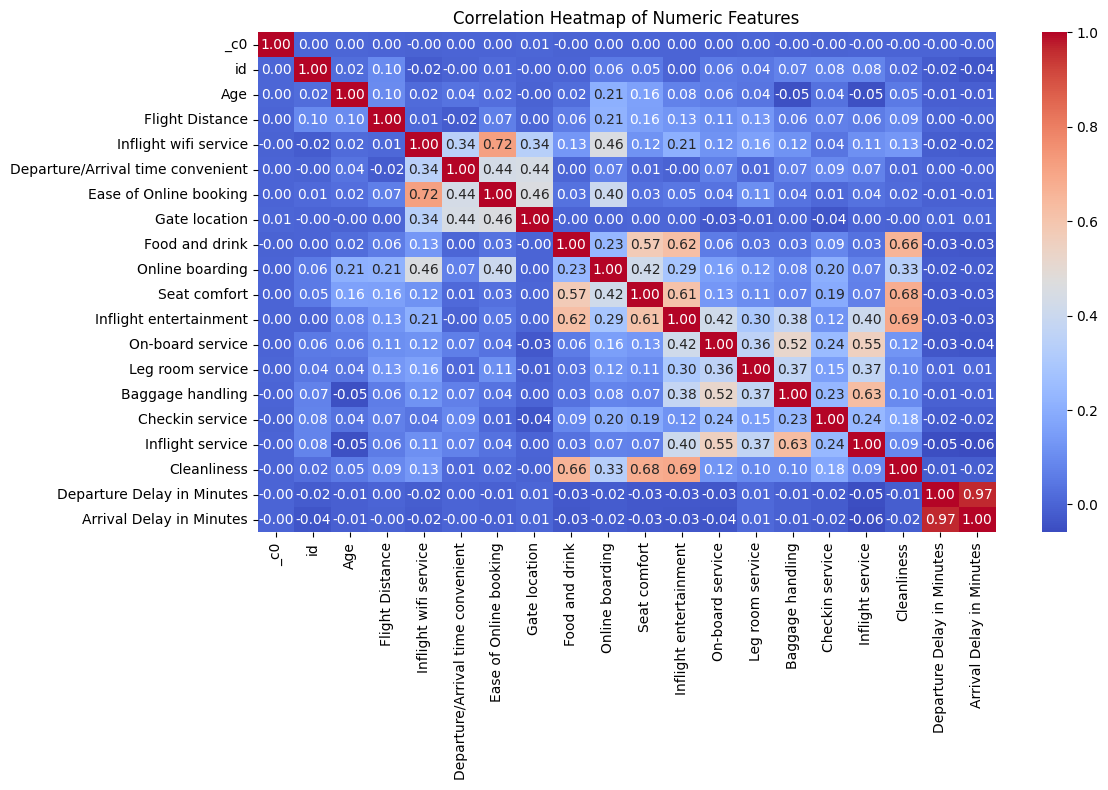

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


### Bar Chart

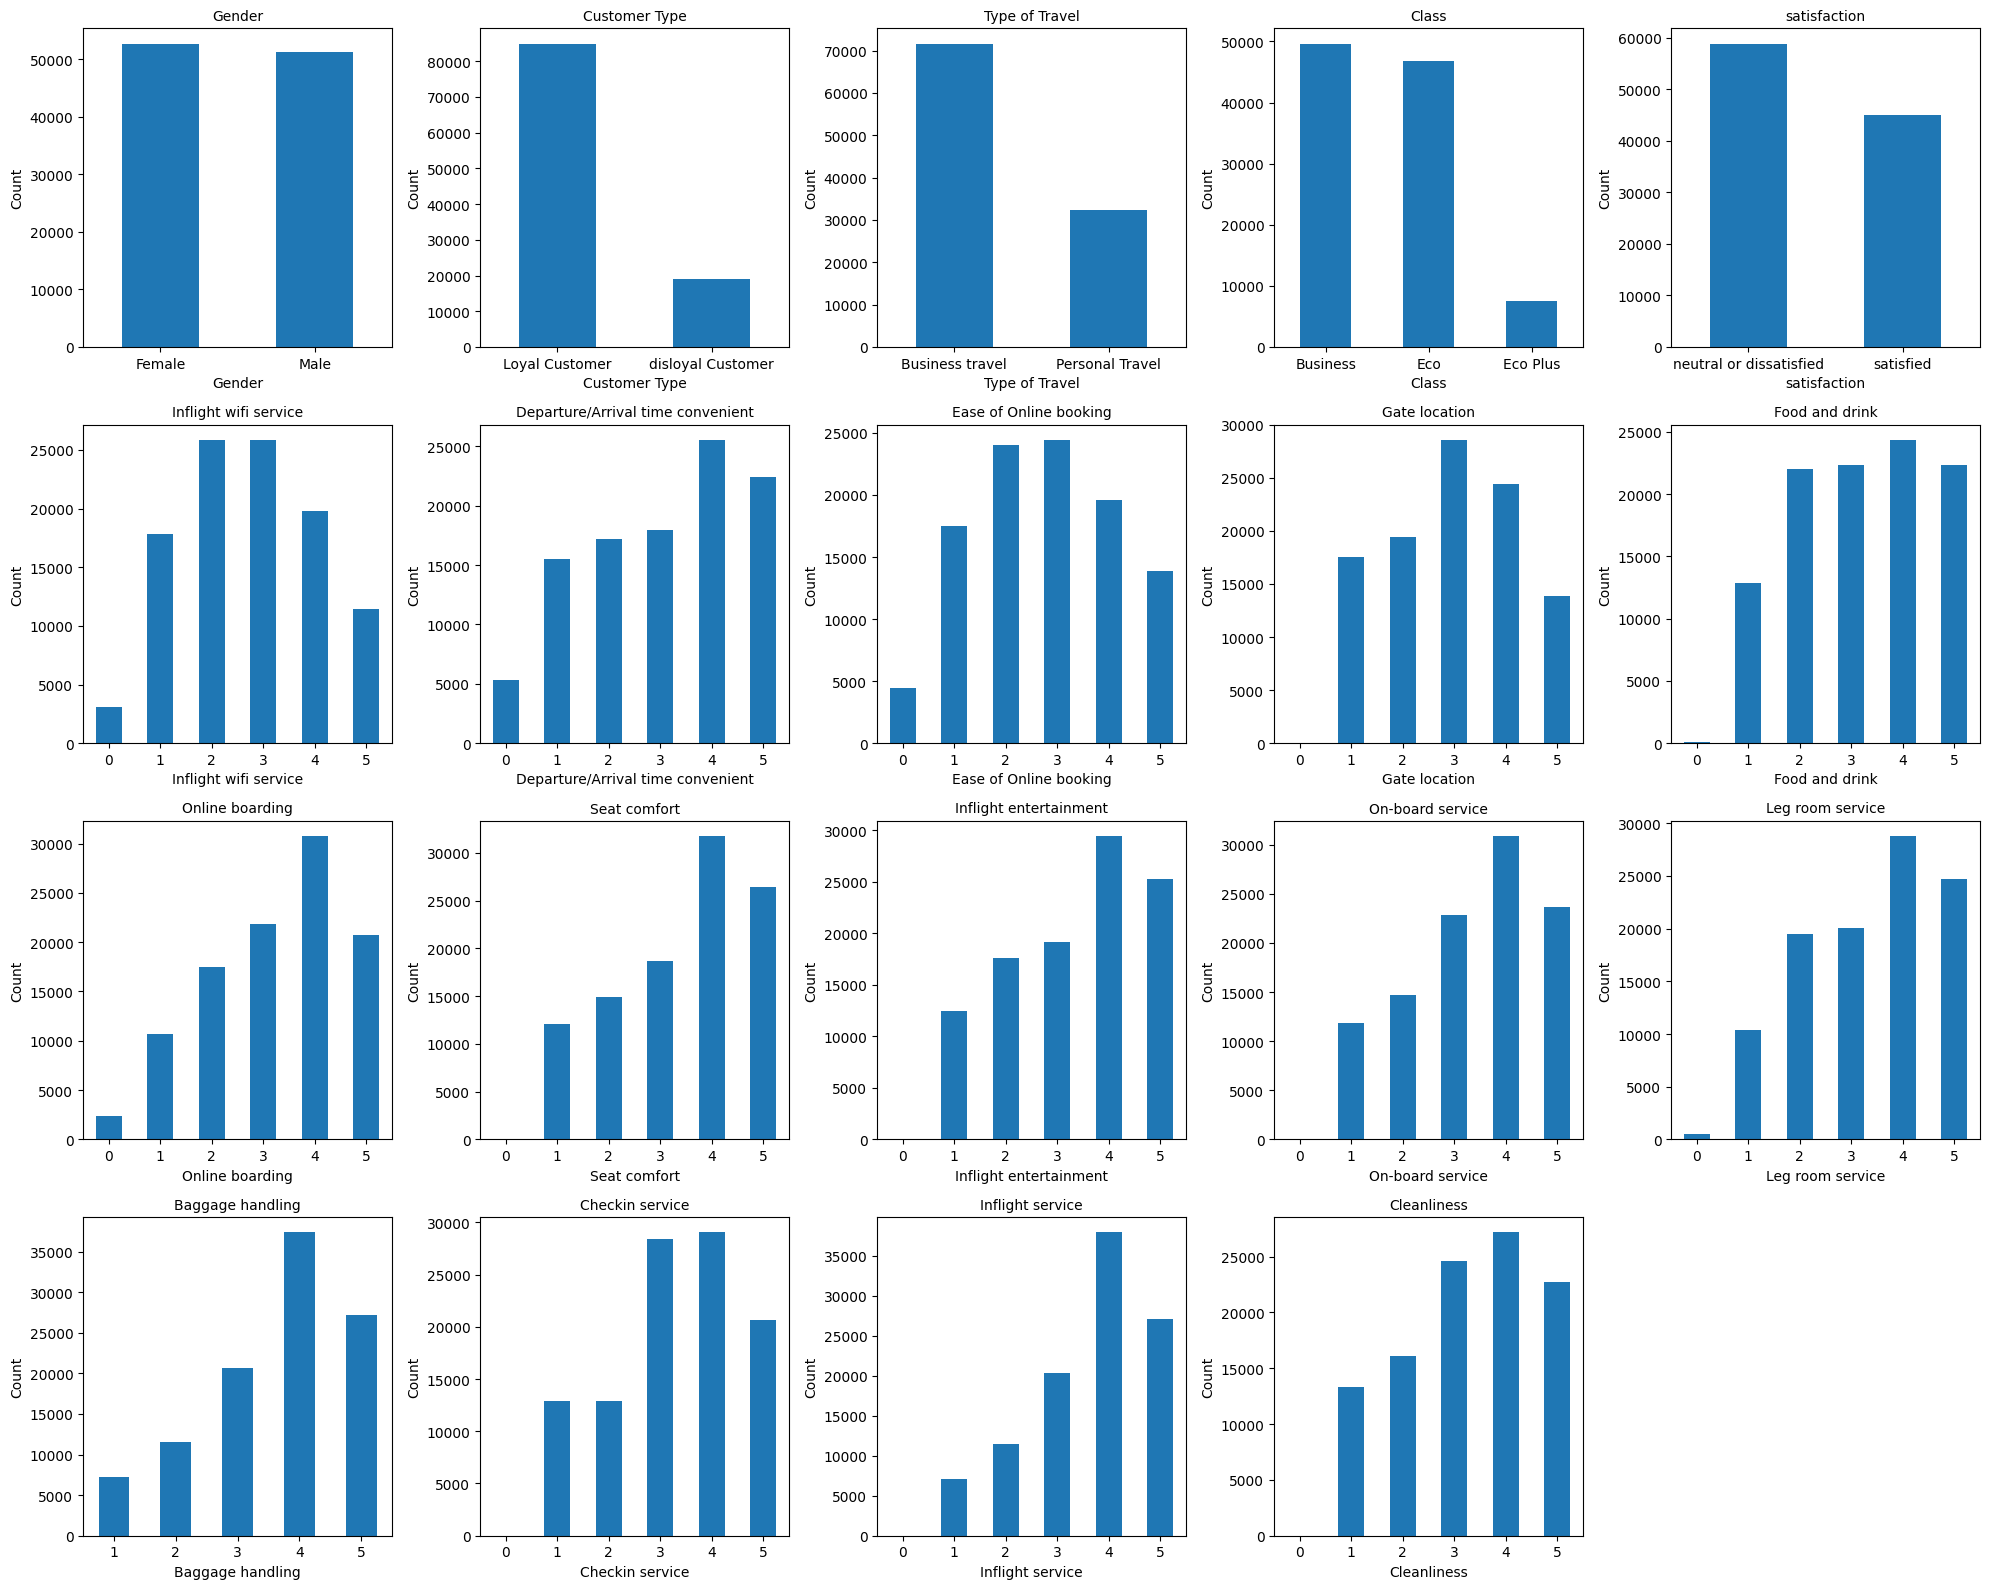

In [ ]:
cols_to_plot = categorical_variables_str + categorical_variables_int
n_plots = len(cols_to_plot)
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 16))  # Adjust figsize as needed
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    value_counts = pd_df[col].value_counts(dropna=False).sort_index()
    value_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=10)
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', labelrotation=0)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Pie Chart

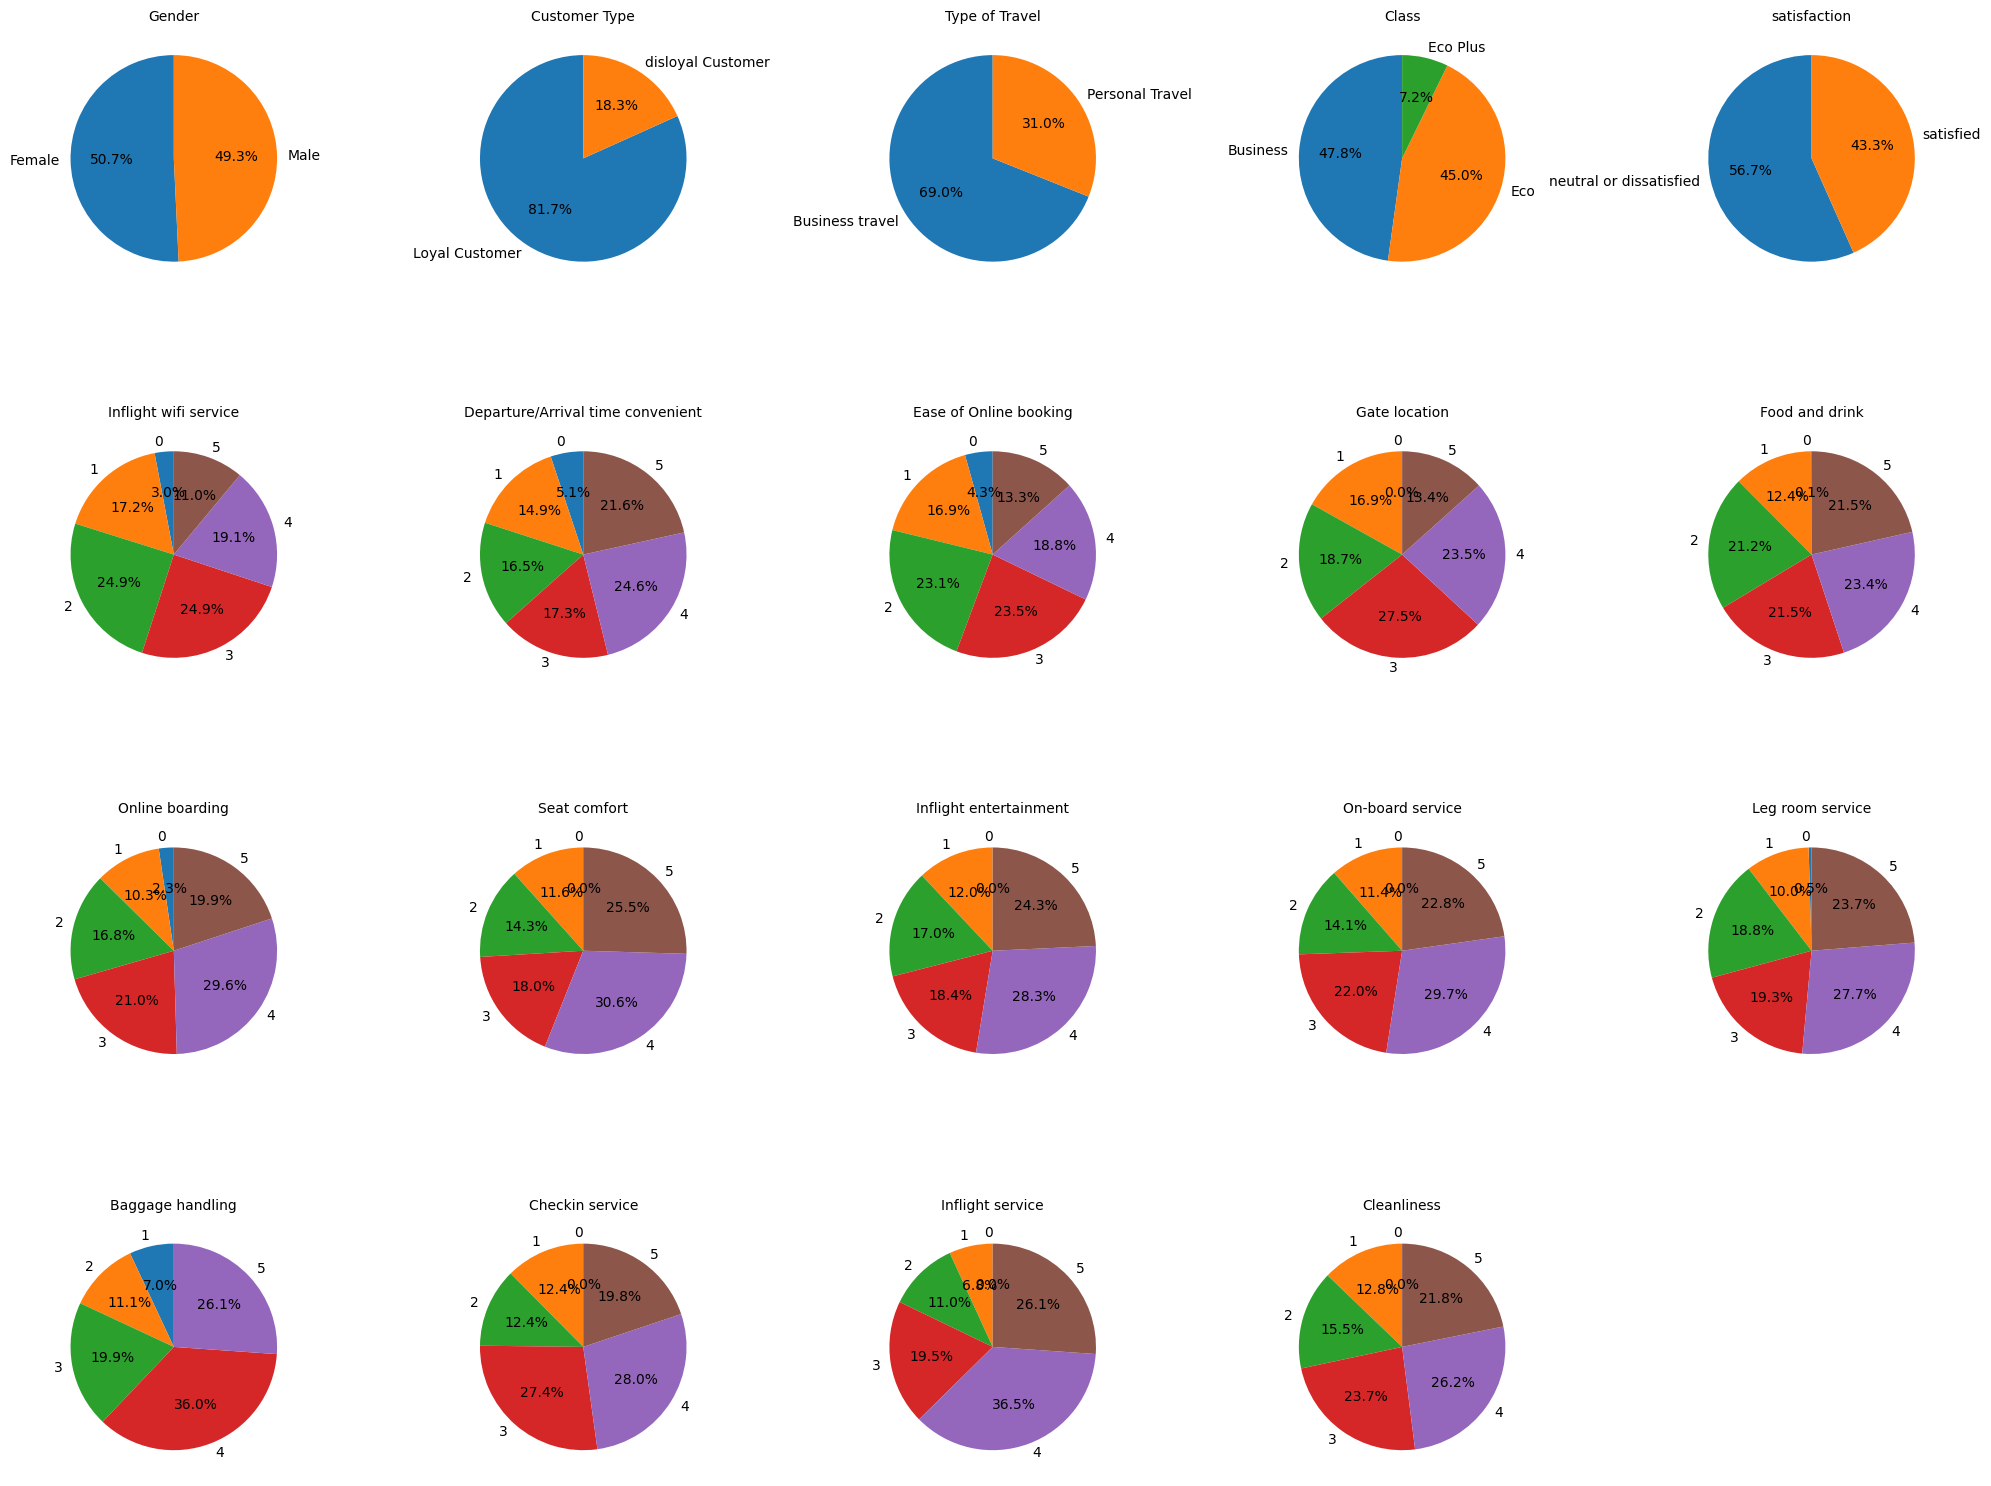

In [ ]:
cols_to_plot = categorical_variables_str + categorical_variables_int
n_plots = len(cols_to_plot)
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    value_counts = pd_df[col].value_counts(dropna=False).sort_index()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"{col}", fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Some conclusions about the considered sample:
*   The sample contains a roughly equal number of male and female
passengers.

*   A significant majority of customers are returning or loyal flyers.

*   Most passengers traveled for business rather than leisure purposes.

*   Approximately half of the travelers were seated in business class.

*   Over 60% of passengers expressed satisfaction with the baggage handling service, giving it a rating of 4 or 5 out of 5.

*   More than half of the passengers found their seats to be comfortable, rating them 4 or 5 out of 5.

### Relationship Between 'Class' and 'satisfaction'

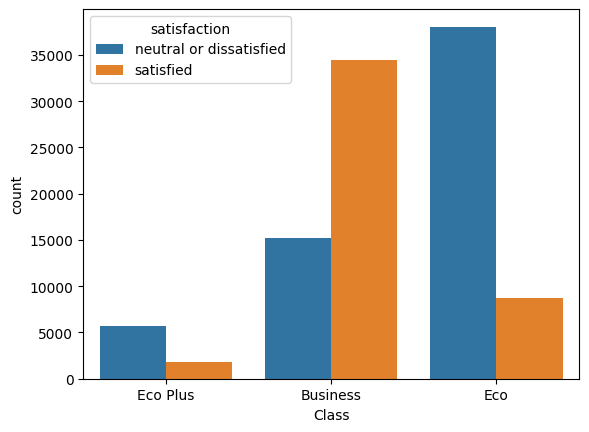

In [ ]:
sns.countplot(x = 'Class', hue = 'satisfaction', data = pd_df)
plt.show()

The chart shows that most economy and economy plus passengers were dissatisfied, while business class passengers were generally satisfied.

### Age Distribution

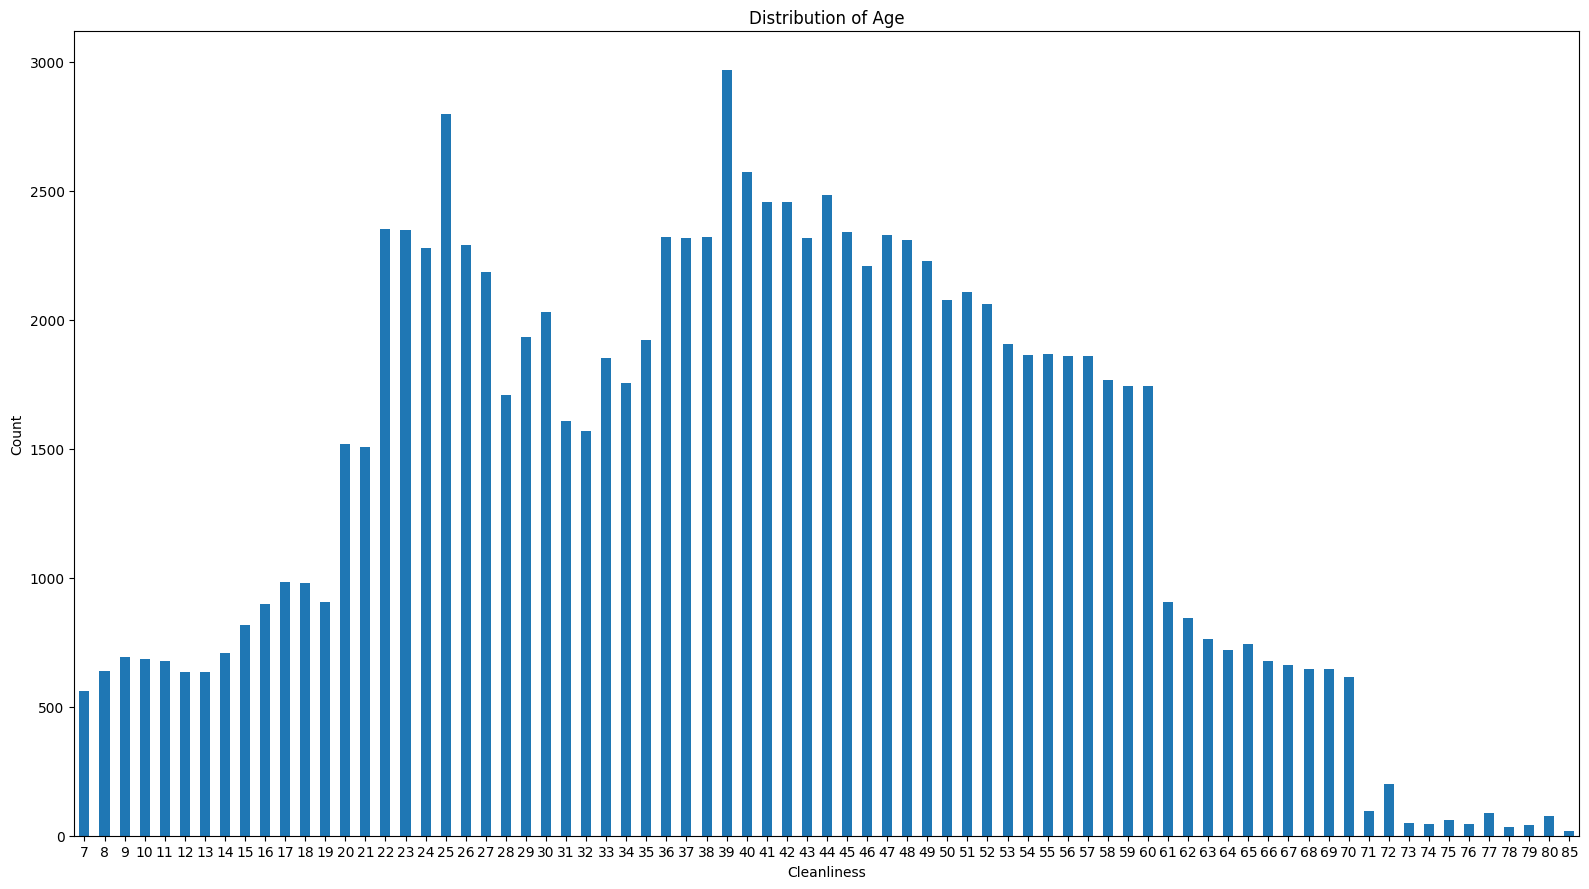

In [ ]:
plt.figure(figsize=(16, 9))
value_counts = pd_df["Age"].value_counts(dropna=False).sort_index()
value_counts.plot(kind='bar')
plt.title(f"Distribution of Age")
plt.ylabel("Count")
plt.xlabel(col)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Relationship Between 'Arrival Delay in Minutes' and 'Departure Delay in Minutes'

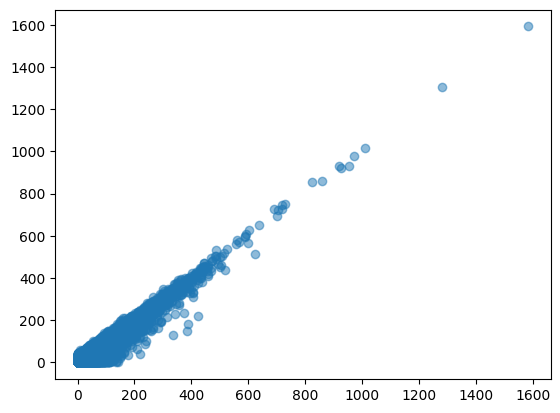

In [ ]:
plt.scatter(pd_df['Arrival Delay in Minutes'], pd_df['Departure Delay in Minutes'], alpha = 0.5)

The points form a roughly straight line from lower left to upper right, suggesting a linear relationship between departure and arrival delays. This makes sense, as delays at departure typically result in similar delays at arrival unless the flight makes up time en route.


## Preprocess

In [ ]:
df.show(5, truncate=False)

+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+-----------------------+
|_c0|id    |Gender|Customer Type    |Age|Type of Travel |Class   |Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+---------

In [ ]:
from pyspark.sql.functions import col, when, sum as spark_sum

# Drop columns
columns_to_drop = ['_c0', 'id']
df_clean = df.drop(*columns_to_drop)
count_null(df_clean)

+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
|Gender|Customer Type|Age|Type of Travel|Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction|
+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+-------

In [ ]:
df_clean.show(5, truncate=False)

+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+-----------------------+
|Gender|Customer Type    |Age|Type of Travel |Class   |Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+-------------

In [ ]:
custom_mappings = {
    "Gender": {'Female': 0, 'Male': 1},
    "Customer Type": {'Loyal Customer': 1, 'disloyal Customer': 0},
    "Type of Travel": {'Business travel': 1, 'Personal Travel': 0},
    "Class": {'Eco': 0, 'Eco Plus': 1, 'Business': 2},
    "satisfaction": {'neutral or dissatisfied': 0, 'satisfied': 1}
}

In [ ]:
# Handle Missing Values
imputer = Imputer(
    inputCols=["Arrival Delay in Minutes"],
    outputCols=["Arrival Delay in Minutes"],
    strategy="median"
    )

scaler_stage = ScaledFeatureExpander(
    inputCols=numeric_variables,
    outputPrefix="_scaled"
    )

custom_label_indexer = CustomLabelIndexer(mappings=custom_mappings)

assembler = VectorAssembler(
    inputCols= categorical_variables_int + ["Age_scaled",
                                            "Flight Distance_scaled",
                                            "Departure Delay in Minutes_scaled",
                                            "Arrival Delay in Minutes_scaled",
                                            "Gender_indexed",
                                            "Customer Type_indexed",
                                            "Type of Travel_indexed",
                                            "Class_indexed"],
    outputCol="features"
)
pipeline = Pipeline(stages=[imputer, scaler_stage, custom_label_indexer, assembler])

df_processed= pipeline.fit(df_clean).transform(df_clean)
df_processed = df_processed.select("features", "satisfaction_indexed")
df_processed.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|features                                                                                                                                                   |satisfaction_indexed|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|[3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,-1.745270848274231,-0.7315352559089661,0.2663913667201996,0.07416880130767822,1.0,1.0,0.0,1.0]    |0                   |
|[3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,-0.9513556361198425,-0.9571789503097534,-0.36137306690216064,-0.2363116443157196,1.0,0.0,1.0,2.0] |0                   |
|[2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,-0.8851960301399231,-0.04758412018418312,-0.387

# Build Model

## Split random

In [ ]:
# Split the dataset into training and testing sets
train, test = df_processed.randomSplit([0.8, 0.2], seed=42)

## Model

In [ ]:
# 1. Determine input feature size
input_size = len(train.select("features").first()[0])

# 2. Define the base MLP model
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="satisfaction_indexed",
    maxIter=100,
    blockSize=128,
    seed=123
)

# 3. Build hyperparameter grid
paramGrid = (
    ParamGridBuilder()
    .addGrid(mlp.layers, [
        [input_size, 5, 2],
        [input_size, 10, 2],
        [input_size, 10, 5, 2]  # 2 hidden layers
    ])
    .addGrid(mlp.maxIter, [100, 200])
    .build()
)

# 4. Binary evaluator (AUC-ROC)
evaluator = BinaryClassificationEvaluator(
    labelCol="satisfaction_indexed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# 5. Set up cross-validation
cv = CrossValidator(
    estimator=mlp,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=2,
    seed=42
)

# 6. Train the cross-validated model
cv_model = cv.fit(train)

# 7. Predict on test set
cv_predictions = cv_model.transform(test)

# 8. Evaluate tuned MLP
auc = evaluator.evaluate(cv_predictions)
print(f"Tuned MLP AUC: {auc:.4f}")

# 9. Show sample predictions
cv_predictions.orderBy(rand(seed=42)).select(
    "satisfaction_indexed", "prediction", "probability"
).show(10, truncate=False)


Tuned MLP AUC: 0.9843
+--------------------+----------+------------------------------------------+
|satisfaction_indexed|prediction|probability                               |
+--------------------+----------+------------------------------------------+
|0                   |1.0       |[0.39602615981650013,0.6039738401835]     |
|0                   |0.0       |[0.9951673247198602,0.0048326752801397775]|
|0                   |0.0       |[0.9827599328441576,0.017240067155842375] |
|0                   |0.0       |[0.9993997658720583,6.002341279417098E-4] |
|1                   |1.0       |[0.04844878939428846,0.9515512106057115]  |
|1                   |1.0       |[0.026550421204752133,0.9734495787952477] |
|0                   |0.0       |[0.9992231499774936,7.768500225063034E-4] |
|1                   |1.0       |[0.06642759261324868,0.9335724073867513]  |
|1                   |1.0       |[0.03194366337675899,0.9680563366232411]  |
|0                   |0.0       |[0.9973452901184623,0

# Bulid App

In [ ]:
cv_model.write().overwrite().save("/content/models/full_streamlit_pipeline")

In [ ]:
!pip install streamlit -q

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.69.72.230


In [ ]:
%%writefile app.py
# Streamlit app: Upload CSV and apply Spark pipeline for prediction
import streamlit as st
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, FloatType, ArrayType, StringType
from pyspark.ml.pipeline import Transformer
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param.shared import Param, Params
from pyspark.ml.linalg import DenseVector

# Start Spark
spark = SparkSession.builder.appName("CSV Prediction").getOrCreate()

# === Custom Transformers ===
class CustomLabelIndexer(Transformer):
    def __init__(self, mappings=None):
        super(CustomLabelIndexer, self).__init__()
        self.mappings = Param(self, "mappings", "dict of column: mapping_dict")
        self._setDefault(mappings={})
        self.setParams(mappings=mappings)

    def setParams(self, mappings=None):
        return self._set(mappings=mappings)

    def _transform(self, dataset):
        mappings = self.getOrDefault(self.mappings)
        for col_name, mapping_dict in mappings.items():
            index_udf = udf(lambda x: mapping_dict.get(x, -1), IntegerType())
            dataset = dataset.withColumn(f"{col_name}_indexed", index_udf(col(col_name)))
        return dataset.drop(*mappings.keys())

class ScaledFeatureExpander(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None, outputPrefix="_scaled", withMean=True, withStd=True):
        super(ScaledFeatureExpander, self).__init__()
        self.inputCols = inputCols
        self.outputPrefix = outputPrefix
        self.withMean = withMean
        self.withStd = withStd

    def _transform(self, df):
        assembler = VectorAssembler(inputCols=self.inputCols, outputCol="numeric_features")
        df = assembler.transform(df)

        scaler = StandardScaler(
            inputCol="numeric_features",
            outputCol="scaled_features",
            withMean=self.withMean,
            withStd=self.withStd
        )
        scaler_model = scaler.fit(df)
        df = scaler_model.transform(df)

        def unpack_vector(v):
            return v.toArray().tolist() if v is not None else [None] * len(self.inputCols)

        unpack_udf = udf(unpack_vector, ArrayType(FloatType()))
        df = df.withColumn("scaled_array", unpack_udf(col("scaled_features")))

        for i, col_name in enumerate(self.inputCols):
            df = df.withColumn(col_name + self.outputPrefix, col("scaled_array").getItem(i))

        return df.drop("numeric_features", "scaled_features", "scaled_array", *self.inputCols)

# === App UI ===
st.title("🛬 Predict Airline Satisfaction")

uploaded_file = st.file_uploader("Upload a CSV file", type="csv")

if uploaded_file is not None:
    pd_df = pd.read_csv(uploaded_file)
    spark_df = spark.createDataFrame(pd_df)

    for col_name in ["_c0", "id"]:
        if col_name in spark_df.columns:
            spark_df = spark_df.drop(col_name)

    numeric_variables = [
        "Age", "Flight Distance",
        "Departure Delay in Minutes", "Arrival Delay in Minutes"
    ]

    categorical_variables_int = [
        'Inflight wifi service', 'Departure/Arrival time convenient',
        'Ease of Online booking', 'Gate location', 'Food and drink',
        'Online boarding', 'Seat comfort', 'Inflight entertainment',
        'On-board service', 'Leg room service', 'Baggage handling',
        'Checkin service', 'Inflight service', 'Cleanliness'
    ]

    categorical_variables_str = [
        "Gender", "Customer Type", "Type of Travel", "Class", "satisfaction"
    ]

    custom_mappings = {
        "Gender": {'Female': 0, 'Male': 1},
        "Customer Type": {'Loyal Customer': 1, 'disloyal Customer': 0},
        "Type of Travel": {'Business travel': 1, 'Personal Travel': 0},
        "Class": {'Eco': 0, 'Eco Plus': 1, 'Business': 2},
        "satisfaction": {'neutral or dissatisfied': 0, 'satisfied': 1}
    }

    imputer = Imputer(inputCols=["Arrival Delay in Minutes"],
                      outputCols=["Arrival Delay in Minutes"], strategy="median")

    scaler_stage = ScaledFeatureExpander(inputCols=numeric_variables, outputPrefix="_scaled")
    custom_label_indexer = CustomLabelIndexer(mappings=custom_mappings)

    assembler = VectorAssembler(
        inputCols=categorical_variables_int + [
            "Age_scaled", "Flight Distance_scaled",
            "Departure Delay in Minutes_scaled", "Arrival Delay in Minutes_scaled",
            "Gender_indexed", "Customer Type_indexed",
            "Type of Travel_indexed", "Class_indexed"
        ],
        outputCol="features"
    )

    pipeline = Pipeline(stages=[imputer, scaler_stage, custom_label_indexer, assembler])
    pipeline_model = pipeline.fit(spark_df)
    processed_df = pipeline_model.transform(spark_df)

    model = CrossValidatorModel.load("/content/models/full_streamlit_pipeline")
    predictions = model.transform(processed_df).select("satisfaction_indexed", "prediction", "probability")

    st.success("✅ Predictions generated!")

    @udf(ArrayType(StringType()))
    def round_probability(vec):
        if vec is not None:
            return [f"{float(x):.3f}" for x in vec]
        return None

    predictions = predictions.withColumn("probability_rounded", round_probability(col("probability")))
    df_clean = predictions.drop("probability").withColumnRenamed("probability_rounded", "probability")

    df_pd = df_clean.toPandas()
    st.dataframe(df_pd)

    st.title("Pie Chart Of Prediction Accuracy")

    import matplotlib.pyplot as plt

    # Calculate correct vs incorrect predictions
    df_pd["correct"] = df_pd["satisfaction_indexed"] == df_pd["prediction"]
    correct_count = df_pd["correct"].sum()
    incorrect_count = len(df_pd) - correct_count

    # Prepare pie chart
    labels = ['Correct', 'Incorrect']
    sizes = [correct_count, incorrect_count]
    colors = ['#1f77b4', '#ff7f0e']
    explode = (0.05, 0)  # explode first slice (Correct)

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    st.pyplot(fig)

    csv = df_pd.to_csv(index=False).encode("utf-8")
    st.download_button("📥 Download Results", data=csv, file_name="predictions.csv", mime="text/csv")


Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.69.72.230:8501

⠼⠴your url is: https://five-laws-notice.loca.lt
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/12 08:24:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/12 08:24:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/12 08:25:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Shiet

In [ ]:
# Initialize Binary Logistic Regression
lr = LogisticRegression(
    featuresCol="features",
    labelCol="satisfaction_indexed",  # Binary target (0 or 1)
    maxIter=500,
    regParam=0.001,
    elasticNetParam=1.0,    # L2 regularization
    family="binomial"       # Default for binary classification
)

# Train model
lr_model = lr.fit(train)

# Predict on test data
predictions = lr_model.transform(test)

# Show predictions
predictions.orderBy(rand(seed=42)).select(
    "satisfaction_indexed", "prediction", "probability"
).show(10, truncate=False)

# Evaluate using Binary evaluator (e.g., AUC)
evaluator = BinaryClassificationEvaluator(
    labelCol="satisfaction_indexed",
    rawPredictionCol="rawPrediction",  # or "probability"
    metricName="areaUnderROC"          # or "areaUnderPR"
)

auc = evaluator.evaluate(predictions)
print(f"Test AUC: {auc:.4f}")

+--------------------+----------+-----------------------------------------+
|satisfaction_indexed|prediction|probability                              |
+--------------------+----------+-----------------------------------------+
|1                   |1.0       |[0.07868973651451085,0.9213102634854892] |
|0                   |0.0       |[0.9741056173148888,0.02589438268511124] |
|1                   |1.0       |[0.34250296302351974,0.6574970369764803] |
|1                   |1.0       |[0.019888688630425026,0.980111311369575] |
|1                   |1.0       |[0.23828479890490184,0.7617152010950982] |
|1                   |1.0       |[0.027629978368731958,0.9723700216312681]|
|1                   |0.0       |[0.6466914663476262,0.3533085336523738]  |
|1                   |1.0       |[0.018803188737191952,0.981196811262808] |
|0                   |1.0       |[0.3342275910708376,0.6657724089291623]  |
|1                   |1.0       |[0.029414085068112786,0.9705859149318872]|
+-----------

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Determine input feature size from training data
input_size = len(train.select("features").first()[0])

# Define binary classification MLP architecture: [input, hidden, output=2 classes]
layers = [input_size, 10, 2]

# Initialize MLP classifier
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="satisfaction_indexed",      # Must contain only 0 or 1
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=123
)

# Train the model
model = mlp.fit(train)

# Predict on test data
predictions = model.transform(test)

# Show predictions
predictions.select("satisfaction_indexed", "prediction", "probability").show(5, truncate=False)

# Evaluate with BinaryClassificationEvaluator (AUC or PR)
evaluator = BinaryClassificationEvaluator(
    labelCol="satisfaction_indexed",
    rawPredictionCol="rawPrediction",  # or use "probability"
    metricName="areaUnderROC"          # or "areaUnderPR"
)

auc = evaluator.evaluate(predictions)
print(f"MLP AUC: {auc:.4f}")


+--------------------+----------+-----------------------------------------+
|satisfaction_indexed|prediction|probability                              |
+--------------------+----------+-----------------------------------------+
|1                   |1.0       |[0.03379946947786893,0.966200530522131]  |
|1                   |1.0       |[6.356810136905333E-6,0.9999936431898632]|
|0                   |0.0       |[0.9834279791555305,0.016572020844469397]|
|1                   |1.0       |[0.00837510712468289,0.9916248928753171] |
|1                   |0.0       |[0.9069423222141904,0.09305767778580967] |
+--------------------+----------+-----------------------------------------+
only showing top 5 rows

MLP AUC: 0.9802


In [ ]:
# 1. Define the base logistic regression model
lr = LogisticRegression(
    featuresCol="features",
    labelCol="satisfaction_indexed",
    family="binomial"  # binary classification
)

# 2. Define hyperparameter grid
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # L2, elastic, L1
    .build()
)

# 3. Define binary evaluator (e.g., AUC-ROC)
evaluator = BinaryClassificationEvaluator(
    labelCol="satisfaction_indexed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# 4. Set up cross-validator
cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=2,
    seed=42
)

# 5. Fit cross-validated model
cv_model = cv.fit(train)

# 6. Make predictions on the test set
cv_predictions = cv_model.transform(test)

# 7. Evaluate tuned model
auc = evaluator.evaluate(cv_predictions)
print(f"Tuned Logistic Regression AUC: {auc:.4f}")

# 8. Optional: Show random predictions
cv_predictions.orderBy(rand(seed=42)).select(
    "satisfaction_indexed", "prediction", "probability"
).show(10, truncate=False)


Tuned Logistic Regression AUC: 0.9256
+--------------------+----------+-----------------------------------------+
|satisfaction_indexed|prediction|probability                              |
+--------------------+----------+-----------------------------------------+
|1                   |1.0       |[0.07868973651451085,0.9213102634854892] |
|0                   |0.0       |[0.9741056173148888,0.02589438268511124] |
|1                   |1.0       |[0.34250296302351974,0.6574970369764803] |
|1                   |1.0       |[0.019888688630425026,0.980111311369575] |
|1                   |1.0       |[0.23828479890490184,0.7617152010950982] |
|1                   |1.0       |[0.027629978368731958,0.9723700216312681]|
|1                   |0.0       |[0.6466914663476262,0.3533085336523738]  |
|1                   |1.0       |[0.018803188737191952,0.981196811262808] |
|0                   |1.0       |[0.3342275910708376,0.6657724089291623]  |
|1                   |1.0       |[0.02941408506811